<a href="https://colab.research.google.com/github/aksj98/EmpiricallyEmergent/blob/main/BERT_Probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for probing BERT on the IMDB movie review dataset 

## Install and imports 

In [ ]:
#@title Install required libraries
!pip install transformers
!pip install torch
!pip install datasets

In [ ]:
#@title Imports
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel, AdamW, Trainer, TrainingArguments, PreTrainedModel
from datasets import load_dataset

## Loading dataset and pre-processing

In [ ]:
#@title Load dataset
dataset = load_dataset("imdb")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
#@title BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#@title DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
#@title Tokenizing the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


In [ ]:
#@title Format the dataset
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

## Modelling 

### Base-BERT

In [ ]:
#@title Load pretrained Base-BERT
bert_base_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#@title Create class for finetuning - for baseBERT
class FineTunedBERT(PreTrainedModel):
    def __init__(self, bert_base_model):
        super(FineTunedBERT, self).__init__(bert_base_model.config)
        self.bert = bert_base_model
        self.dropout = nn.Dropout(0.1)
        self.num_labels=2
        self.fc = nn.Linear(768, self.num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)

        if labels is not None:
            loss_fn = CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits
        else:
            return logits

model = FineTunedBERT(bert_base_model)


### DistilBERT

In [ ]:
#@title Load pretrained model
distilbert_base_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
#@title Custom finetuning class
class FineTunedDistilBERT(PreTrainedModel):
    def __init__(self, distilbert_base_model):
        super(FineTunedDistilBERT, self).__init__(distilbert_base_model.config)
        self.distilbert = distilbert_base_model
        self.dropout = nn.Dropout(0.1)
        self.num_labels = 2
        self.fc = nn.Linear(768, self.num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)

        if labels is not None:
            loss_fn = CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits
        else:
            return logits


In [ ]:
#@title Init model
model = FineTunedDistilBERT(distilbert_base_model)
model.config = distilbert_base_model.config

## Training

In [ ]:
#@title Training settings
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1, #only 1 epoch since I don't like watching the world burn :)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    save_steps=1000,
    seed=42,
    learning_rate=2e-5,
)

In [ ]:
#@title Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.285200,0.217190


TrainOutput(global_step=3125, training_loss=0.29099675750732423, metrics={'train_runtime': 1700.6943, 'train_samples_per_second': 14.7, 'train_steps_per_second': 1.837, 'total_flos': 3266327500800000.0, 'train_loss': 0.29099675750732423, 'epoch': 1.0})

In [ ]:
from google.colab import drive
drive.mount("./content")

Mounted at ./content


In [ ]:
import os
os.chdir("./content/MyDrive/EE")

In [ ]:
#@title Save weights
save_directory = "finetuned_distilbert"

# Save the model weights and configuration
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('finetuned_distilbert/tokenizer_config.json',
 'finetuned_distilbert/special_tokens_map.json',
 'finetuned_distilbert/vocab.txt',
 'finetuned_distilbert/added_tokens.json')

## Evaluation

In [ ]:
#@title Evaluation
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.21719017624855042, 'eval_runtime': 439.8071, 'eval_samples_per_second': 56.843, 'eval_steps_per_second': 7.105, 'epoch': 1.0}


## Visualization

### Visualization via dimensionality reduction and relationship b/w weights

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def visualize_hidden_states(sentence, model, tokenizer, layer_idx):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

    device = next(model.parameters()).device

    # Move the input tensors to the same device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Get the hidden states
    with torch.no_grad():
        outputs = model.distilbert(inputs['input_ids'], attention_mask=inputs['attention_mask'],output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx].squeeze().cpu().numpy()

    # Perform dimensionality reduction using UMAP
    reducer = umap.UMAP()
    reduced_hidden_states = reducer.fit_transform(hidden_states)

    # Create a scatter plot of the reduced hidden states
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_hidden_states[:, 0], y=reduced_hidden_states[:, 1])
    plt.title(f"Hidden States at Layer {layer_idx} for Sentence: '{sentence}'")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()


/usr/local/lib/python3.9/dist-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


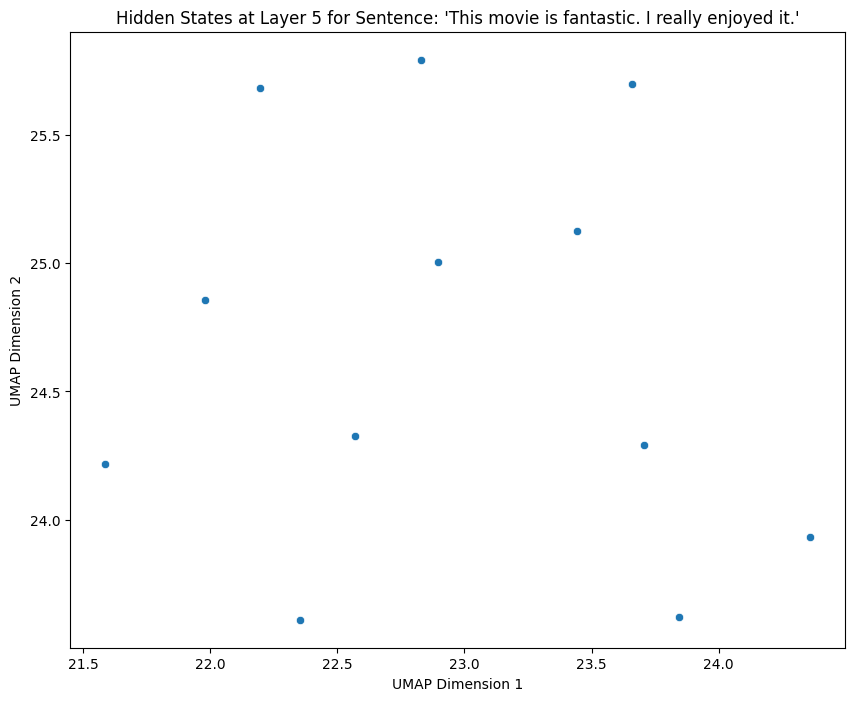

In [ ]:
sentence = "This movie is fantastic. I really enjoyed it."
layer_idx = 5
visualize_hidden_states(sentence, model, tokenizer, layer_idx)

### Visualization via subsampling layer neurons

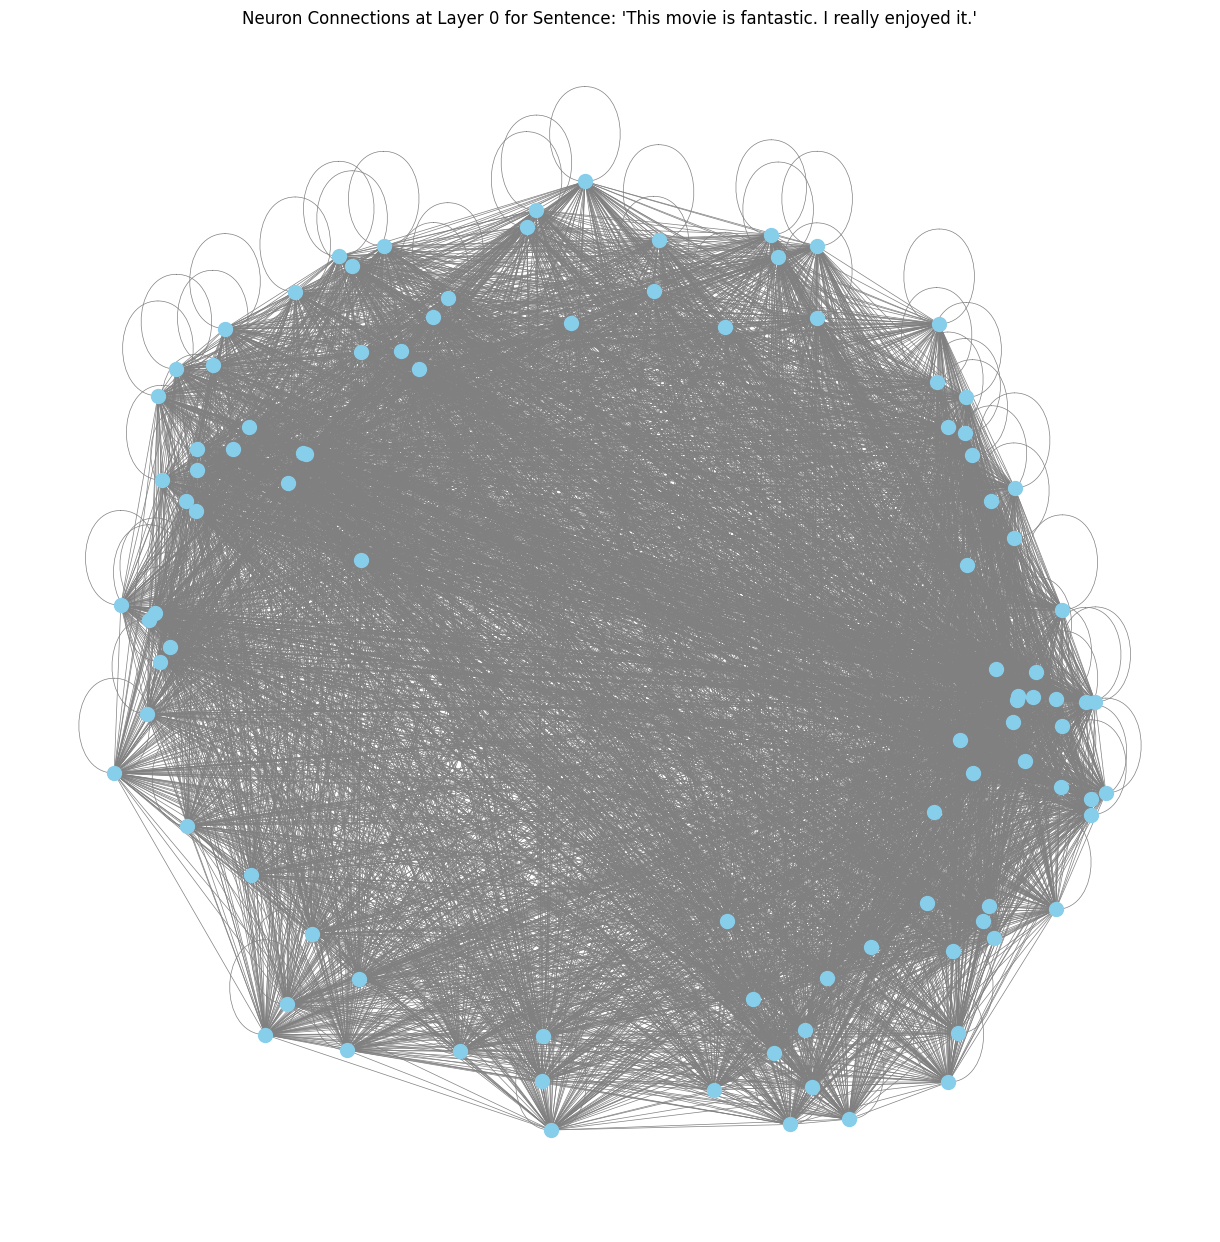

In [ ]:
import networkx as nx
import numpy as np

def visualize_neuron_connections(sentence, model, tokenizer, layer_idx, n_neurons=100):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

    # Get the device on which the model is running
    device = next(model.parameters()).device

    # Move the input tensors to the same device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the hidden states
    with torch.no_grad():
        outputs = model.distilbert(inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx].squeeze().cpu().numpy()

    # Select a subset of neurons
    hidden_states_subset = hidden_states[:, :n_neurons]

    # Calculate the correlation matrix
    correlation_matrix = np.corrcoef(hidden_states_subset.T)

    # Create a graph from the correlation matrix
    graph = nx.from_numpy_array(correlation_matrix)

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_color="skyblue", node_size=100, edge_color="gray", with_labels=False, width=0.5)
    plt.title(f"Neuron Connections at Layer {layer_idx} for Sentence: '{sentence}'")
    plt.show()

# Example usage
sentence = "This movie is fantastic. I really enjoyed it."
layer_idx = 0
visualize_neuron_connections(sentence, model, tokenizer, layer_idx, n_neurons=100)


### Visualization via heatmaps using layer weights

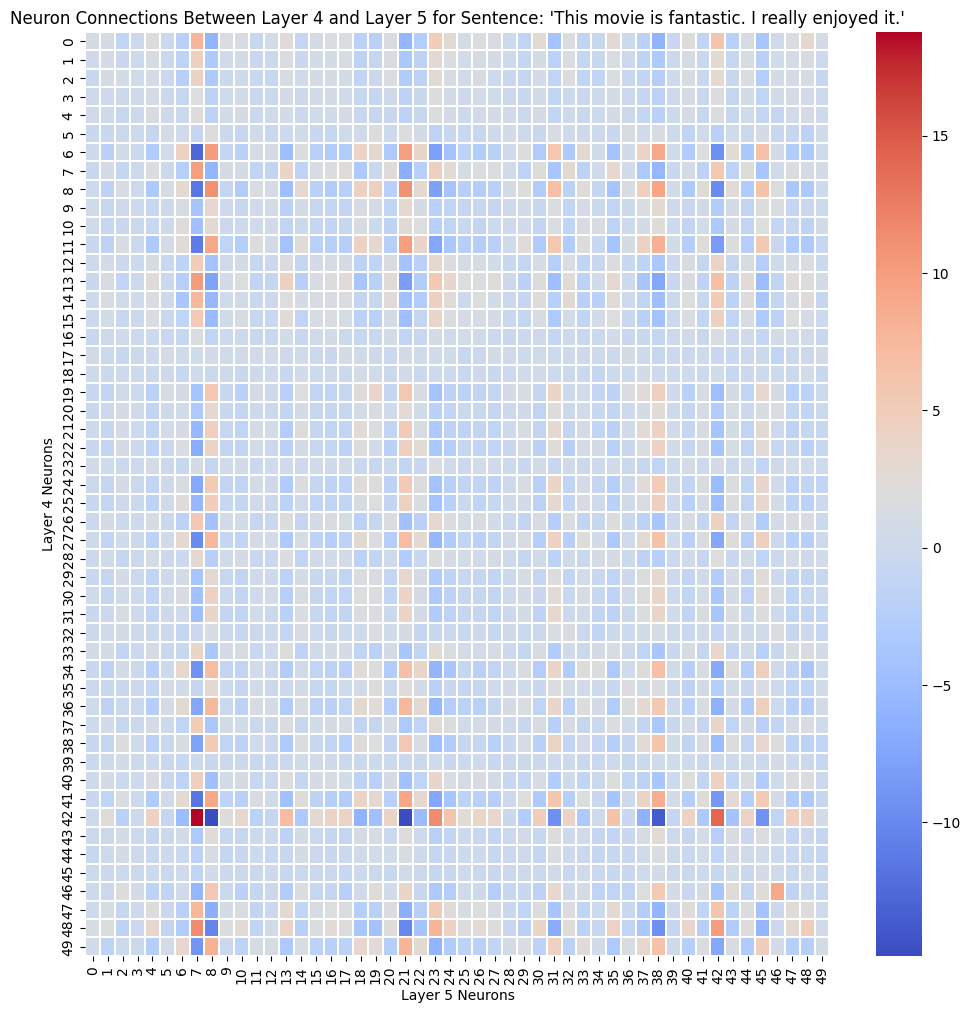

In [ ]:
import seaborn as sns
import numpy as np

def visualize_layer_connections_heatmap_subset(sentence, model, tokenizer, layer1_idx, layer2_idx, n_neurons1=100, n_neurons2=100):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

    # Get the device on which the model is running
    device = next(model.parameters()).device

    # Move the input tensors to the same device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the hidden states
    with torch.no_grad():
        outputs = model.distilbert(inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        hidden_states_layer1 = outputs.hidden_states[layer1_idx].squeeze().cpu().numpy()[:, :n_neurons1]
        hidden_states_layer2 = outputs.hidden_states[layer2_idx].squeeze().cpu().numpy()[:, :n_neurons2]

    # Compute the pairwise dot products between neurons in consecutive layers
    dot_products = np.dot(hidden_states_layer1.T, hidden_states_layer2)

    # Plot the heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(dot_products, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.1, cbar=True)
    plt.xlabel(f"Layer {layer2_idx} Neurons")
    plt.ylabel(f"Layer {layer1_idx} Neurons")
    plt.title(f"Neuron Connections Between Layer {layer1_idx} and Layer {layer2_idx} for Sentence: '{sentence}'")
    plt.show()

# Example usage
sentence = "This movie is fantastic. I really enjoyed it."
layer1_idx = 4
layer2_idx = 5
n_neurons1 = 50
n_neurons2 = 50
visualize_layer_connections_heatmap_subset(sentence, model, tokenizer, layer1_idx, layer2_idx, n_neurons1, n_neurons2)


### Visualization of multiple layers using weights and graph visualization

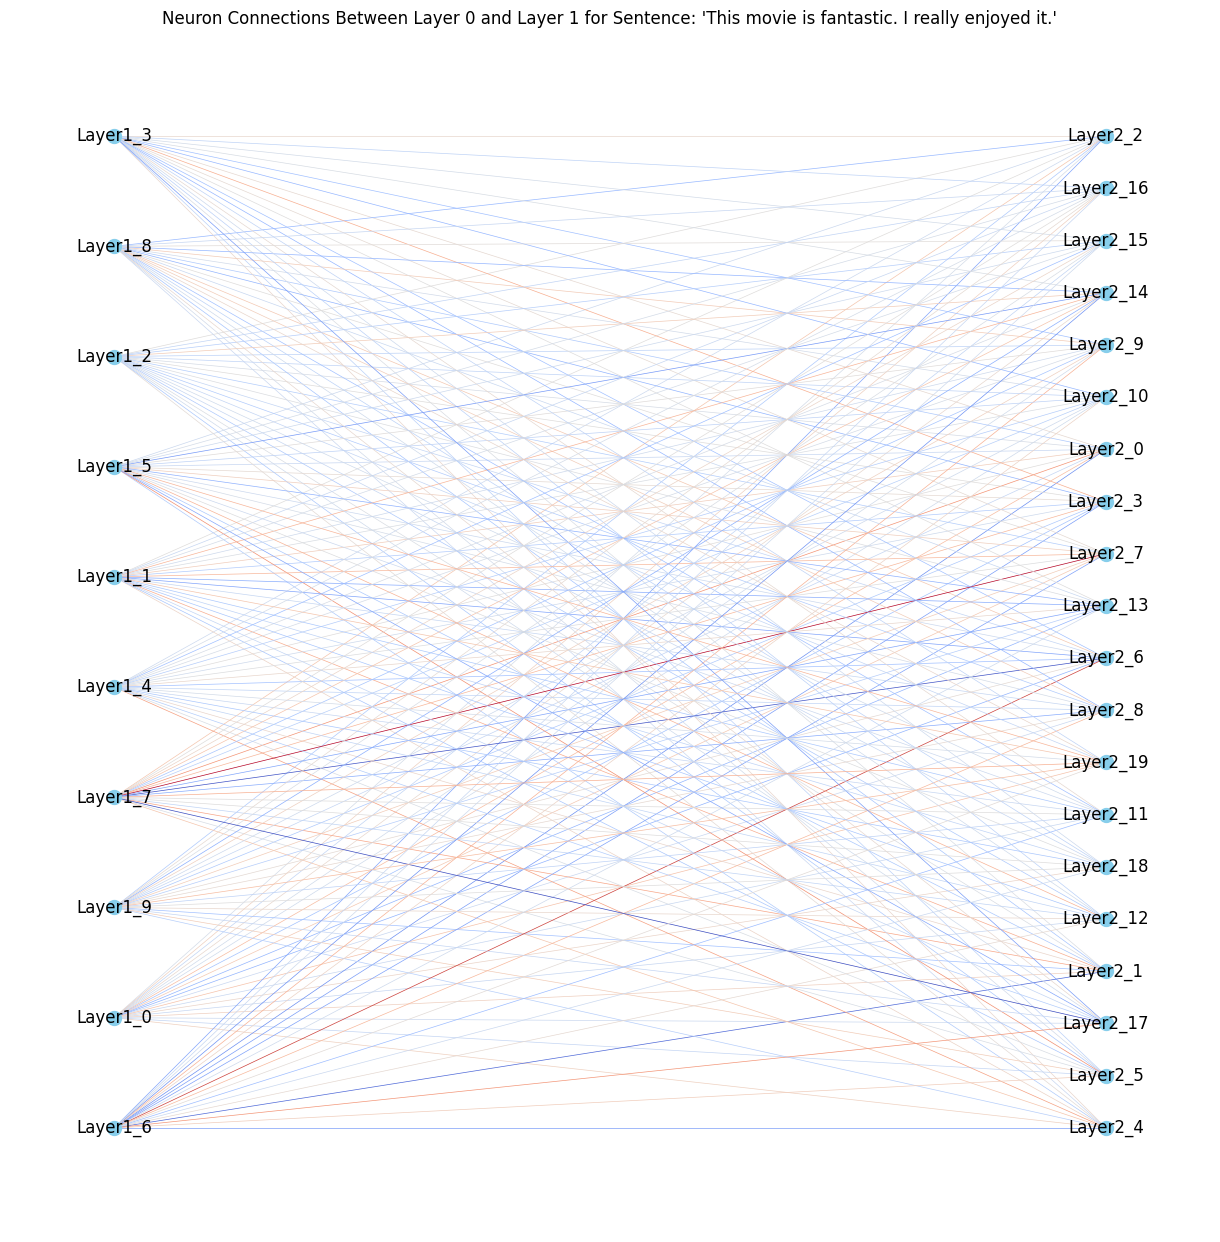

In [ ]:
def visualize_layer_connections_network_subset(sentence, model, tokenizer, layer1_idx, layer2_idx, n_neurons1=100, n_neurons2=100):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

    # Get the device on which the model is running
    device = next(model.parameters()).device

    # Move the input tensors to the same device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the hidden states
    with torch.no_grad():
        outputs = model.distilbert(inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        hidden_states_layer1 = outputs.hidden_states[layer1_idx].squeeze().cpu().numpy()[:, :n_neurons1]
        hidden_states_layer2 = outputs.hidden_states[layer2_idx].squeeze().cpu().numpy()[:, :n_neurons2]

    # Compute the pairwise dot products between neurons in consecutive layers
    dot_products = np.dot(hidden_states_layer1.T, hidden_states_layer2)

    # Create a bipartite graph from the dot products
    graph = nx.Graph()
    n1, n2 = dot_products.shape

    for i in range(n1):
        for j in range(n2):
            graph.add_edge(f"Layer1_{i}", f"Layer2_{j}", weight=dot_products[i, j])

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.bipartite_layout(graph, [f"Layer1_{i}" for i in range(n1)])
    edge_colors = [graph[u][v]['weight'] for u, v in graph.edges()]
    nx.draw(graph, pos, node_color="skyblue", node_size=100, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, with_labels=True, width=0.5)
    plt.title(f"Neuron Connections Between Layer {layer1_idx} and Layer {layer2_idx} for Sentence: '{sentence}'")
    plt.show()

# Example usage
sentence = "This movie is fantastic. I really enjoyed it."
layer1_idx = 0
layer2_idx = 1
n_neurons1 = 10
n_neurons2 = 20
visualize_layer_connections_network_subset(sentence, model, tokenizer, layer1_idx, layer2_idx, n_neurons1, n_neurons2)
